In [1]:
import torch
print(torch.__version__)

2.0.0+cu117


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

device = torch.device("cuda")

True
2


In [3]:
#!pip install segmentation_models_pytorch

In [4]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1                       # model output channels (number of classes in your dataset)
).to(device)

In [5]:
import os
import torchvision.transforms as transforms
import numpy as np

from PIL import Image

# data from here https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies

images_path = "./data/Water Bodies Dataset/Images"
masks_path = "./data/Water Bodies Dataset/Masks"

IMAGES_WITH = 128
IMAGES_HEIGHT = 128

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((IMAGES_WITH, IMAGES_HEIGHT), antialias=True)
])

def format_image(path):
    image = Image.open(path)
    image = transform(image)
    image = image / 255
    return image.numpy()

def format_mask(path):
    mask = Image.open(path)
    mask = transform(mask)
    mask = mask[0]
    mask = mask > 128
    return [mask.numpy()]

images = []
masks = []
for path in os.listdir(images_path):
    images.append(format_image(images_path + "/" + path))
    masks.append(format_mask(masks_path + "/" + path))

images = np.array(images, dtype='float32')
masks = np.array(masks, dtype='float32')

print("dataset size")
print(images.shape)
print(masks.shape)

split = 0.8

images_train = images[:int(images.shape[0]*split)]
masks_train = masks[:int(masks.shape[0]*split)]

print("train size")
print(images_train.shape)
print(masks_train.shape)

images_val = images[int(images.shape[0]*split):]
masks_val = masks[int(masks.shape[0]*split):]

print("validation size")
print(images_val.shape)
print(masks_val.shape)

dataset size
(2841, 3, 128, 128)
(2841, 1, 128, 128)
train size
(2272, 3, 128, 128)
(2272, 1, 128, 128)
validation size
(569, 3, 128, 128)
(569, 1, 128, 128)


In [6]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

train_loss = []
val_loss = []

for epoch in range(num_epochs):
    totalTrainLoss = 0
    totalTestLoss = 0

    for i in range(len(images_train)):
        model.train()

        tensor_image = torch.from_numpy(np.array([images_train[i]])).to(device)
        tensor_mask = torch.from_numpy(np.array([masks_train[i]])).to(device)

        outputs = model(tensor_image)
        loss = criterion(outputs, tensor_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalTrainLoss += loss


    with torch.no_grad():
        model.eval()

        for i in range(len(images_val)):
            tensor_image = torch.from_numpy(np.array([images_val[i]])).to(device)
            tensor_mask = torch.from_numpy(np.array([masks_val[i]])).to(device)

            outputs = model(tensor_image)
            loss = criterion(outputs, tensor_mask)

            totalTestLoss += loss

    avgTrainLoss = totalTrainLoss / len(images_train)
    avgTestLoss = totalTestLoss / len(images_val)

    train_loss.append(avgTrainLoss.cpu().detach().numpy())
    val_loss.append(avgTestLoss.cpu().detach().numpy())

    print("[INFO] EPOCH: {}/{}".format(epoch + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))

[INFO] EPOCH: 1/5
Train loss: 0.146064, Test loss: 0.1963
[INFO] EPOCH: 2/5
Train loss: 0.112550, Test loss: 0.1713
[INFO] EPOCH: 3/5
Train loss: 0.101079, Test loss: 0.1648
[INFO] EPOCH: 4/5
Train loss: 0.091770, Test loss: 0.1545
[INFO] EPOCH: 5/5
Train loss: 0.085718, Test loss: 0.1641


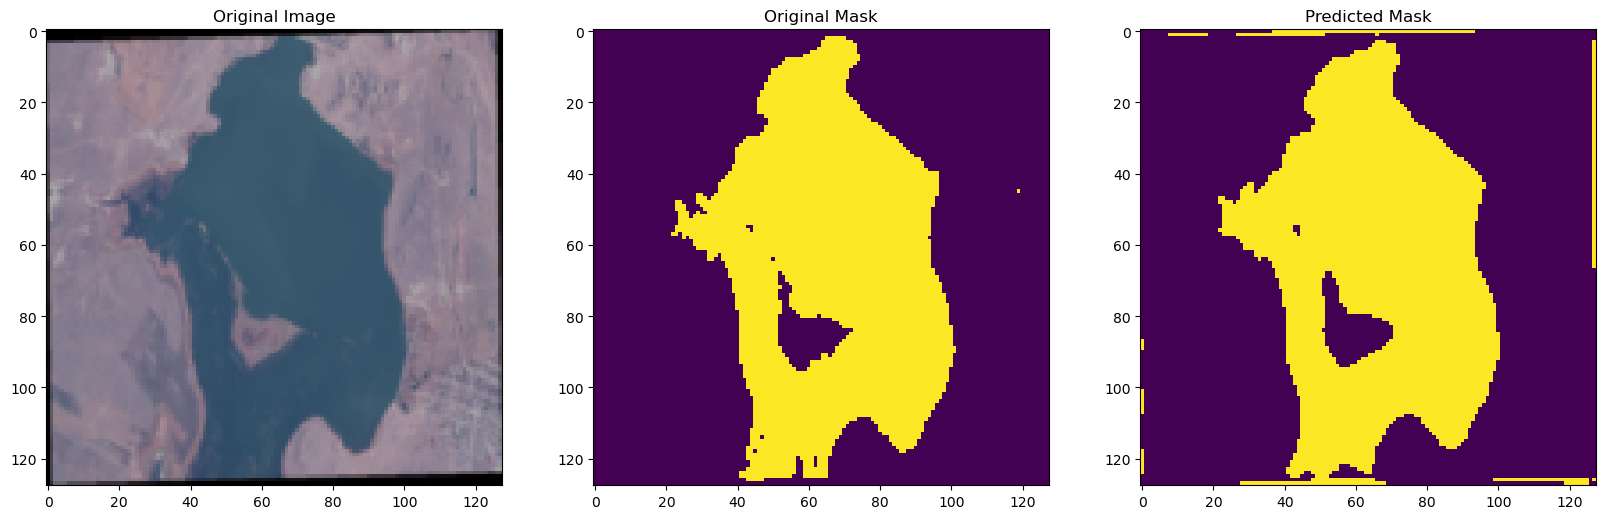

In [13]:
import random
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 3, figsize=(20,20))

rand_num = random.randint(0, images_train.shape[0])

original_img = images_train[rand_num]
original_img_transp = np.moveaxis(original_img, 0, -1)
original_img_transp = np.moveaxis(original_img_transp, 0, 1)
axes[0].imshow(original_img_transp)
axes[0].title.set_text('Original Image')

original_mask = masks_train[rand_num]
original_mask = np.moveaxis(original_mask, 0, -1)
original_mask = np.moveaxis(original_mask, 0, 1)
axes[1].imshow(original_mask)
axes[1].title.set_text('Original Mask')

img = torch.from_numpy(np.array([original_img]))
img = img.to(device)
predicted_mask = model(img)[0]
predicted_mask = predicted_mask.cpu()
predicted_mask = predicted_mask.detach().numpy()
predicted_mask = np.moveaxis(predicted_mask, 0, -1)
predicted_mask = np.moveaxis(predicted_mask, 0, 1)
predicted_mask[predicted_mask>0.5] = 1
predicted_mask[predicted_mask<=0.5] = 0
axes[2].imshow(predicted_mask)
axes[2].title.set_text('Predicted Mask')